In [1]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import sqlite3
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from collections import defaultdict
import seaborn as sns

In [2]:
#pull in data
con = sqlite3.connect('nba.db')

team_basic_boxscores_df = pd.read_sql('select * from team_basic_boxscores', con)
team_advanced_boxscores_df = pd.read_sql('select * from team_advanced_boxscores', con)

team_boxscores_df = team_basic_boxscores_df.merge(team_advanced_boxscores_df, how='inner', on=['GAME_ID', 'TEAM_ID'])

pd.set_option('display.max_columns', None)
team_boxscores_df.head()

,SEASON,TEAM_ID,TEAM_ABBREVIATION_x,TEAM_NAME_x,GAME_ID,GAME_DATE,MATCHUP,WL,MIN_x,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_NAME_y,TEAM_ABBREVIATION_y,TEAM_CITY,MIN_y,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
0,2021-22,1610612747,LAL,Los Angeles Lakers,0022100002,2021-10-19,LAL vs. GSW,L,240,45,95,0.474,15,42,0.357,9,19,0.474,5,40,45,21,7,4,18,25,114,-7,Lakers,LAL,Los Angeles,240:00,98.0,101.8,106.0,107.1,-8.0,-5.3,0.467,1.17,14.8,0.189,0.759,0.477,15.469,16.1,0.553,0.551,1.0,0.198,115.28,112.5,93.75,112.0,0.422
1,2021-22,1610612744,GSW,Golden State Warriors,0022100002,2021-10-19,GSW @ LAL,W,240,41,93,0.441,14,39,0.359,25,30,0.833,9,41,50,30,9,2,17,18,121,7,Warriors,GSW,Golden State,240:00,106.0,107.1,98.0,101.8,8.0,5.3,0.732,1.76,19.6,0.241,0.811,0.523,14.886,15.0,0.516,0.570,1.0,0.200,115.28,112.5,93.75,113.0,0.578
2,2021-22,1610612751,BKN,Brooklyn Nets,0022100001,2021-10-19,BKN @ MIL,L,240,37,84,0.440,17,32,0.531,13,23,0.565,5,39,44,19,3,9,13,17,104,-23,Nets,BKN,Brooklyn,240:00,101.8,102.0,117.7,124.5,-15.8,-22.5,0.514,1.46,15.1,0.176,0.707,0.459,12.730,12.7,0.542,0.552,1.0,0.200,105.02,102.0,85.00,102.0,0.407
3,2021-22,1610612749,MIL,Milwaukee Bucks,0022100001,2021-10-19,MIL vs. BKN,W,240,48,105,0.457,17,45,0.378,14,18,0.778,13,41,54,25,8,9,8,19,127,23,Bucks,MIL,Milwaukee,240:00,117.7,124.5,101.8,102.0,15.8,22.5,0.521,3.13,17.1,0.293,0.824,0.541,7.413,7.8,0.538,0.562,1.0,0.194,105.02,102.0,85.00,102.0,0.593
4,2021-22,1610612754,IND,Indiana Pacers,0022100003,2021-10-20,IND @ CHA,L,240,42,90,0.467,17,47,0.362,21,24,0.875,8,43,51,29,2,10,17,24,122,-1,Pacers,IND,Indiana,240:00,111.4,114.0,107.1,116.0,4.3,-2.0,0.690,1.71,19.8,0.255,0.667,0.487,15.517,15.9,0.561,0.607,1.0,0.199,112.22,106.5,88.75,107.0,0.520


In [3]:
team_boxscores_df.drop(columns=['TEAM_NAME_y', 'TEAM_ABBREVIATION_y', 'MIN_y'], inplace=True)
team_boxscores_df.rename(columns={'TEAM_ABBREVIATION_x':'TEAM_ABBREVIATION', 'TEAM_NAME_x':'TEAM_NAME', 'MIN_x':'MIN'}, inplace=True)
team_boxscores_df.columns

Index(['SEASON', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'TEAM_CITY',
       'E_OFF_RATING', 'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING',
       'E_NET_RATING', 'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO',
       'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'E_TM_TOV_PCT', 'TM_TOV_PCT',
       'EFG_PCT', 'TS_PCT', 'USG_PCT', 'E_USG_PCT', 'E_PACE', 'PACE',
       'PACE_PER40', 'POSS', 'PIE'],
      dtype='object')

In [4]:
#add home team flag
team_boxscores_df['HOME_TEAM'] = team_boxscores_df['MATCHUP'].str[4] == 'v'
team_boxscores_df['HOME_TEAM']

0         True
1        False
2        False
3         True
4        False
         ...  
56299    False
56300    False
56301     True
56302    False
56303     True
Name: HOME_TEAM, Length: 56304, dtype: bool

In [5]:
#reformat so each game is represented by a single row
home_team_boxscores_df = team_boxscores_df[team_boxscores_df['HOME_TEAM']==True]
away_team_boxscores_df = team_boxscores_df[team_boxscores_df['HOME_TEAM']==False]

team_boxscores_df = home_team_boxscores_df.merge(away_team_boxscores_df, how='inner', on='GAME_ID', suffixes=('_HOME', '_AWAY'))

In [6]:
#remove redundant/unnecessary columns
team_boxscores_df.rename(columns={'SEASON_HOME':'SEASON',
                                  'GAME_DATE_HOME':'GAME_DATE',
                                  'MATCHUP_AWAY':'MATCHUP',}, inplace=True)
team_boxscores_df.drop(columns=['SEASON_AWAY',
                                'GAME_DATE_AWAY',
                                'MATCHUP_HOME',
                                'TEAM_ABBREVIATION_HOME',
                                'TEAM_ABBREVIATION_AWAY',
                                'TEAM_NAME_HOME',
                                'TEAM_NAME_AWAY',
                                'MIN_HOME',
                                'MIN_AWAY',
                                'HOME_TEAM_HOME',
                                'HOME_TEAM_AWAY',
                                'MATCHUP'], inplace=True)
#sort by game date
team_boxscores_df['GAME_DATE'] = pd.to_datetime(team_boxscores_df['GAME_DATE'], format='%Y/%m/%d')
team_boxscores_df.sort_values(by='GAME_DATE', ascending=False, inplace=True)

team_boxscores_df.head()

,SEASON,TEAM_ID_HOME,GAME_ID,GAME_DATE,WL_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,TEAM_CITY_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,TEAM_ID_AWAY,WL_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,TEAM_CITY_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY
1314,2021-22,1610612738,0042100404,2022-06-10,L,34,85,0.400,15,38,0.395,14,19,0.737,11,31,42,22,8,6,16,17,97,-10,Boston,98.6,101.0,109.6,111.5,-11.0,-10.4,0.647,1.38,16.7,0.264,0.615,0.438,16.267,16.7,0.488,0.519,1.0,0.196,97.98,96.0,80.00,96.0,0.448,1610612744,W,40,91,0.440,15,43,0.349,12,15,0.800,16,39,55,20,10,5,16,21,107,10,Golden State,109.6,111.5,98.6,101.0,11.0,10.4,0.500,1.25,15.0,0.385,0.736,0.562,16.393,16.7,0.522,0.548,1.0,0.201,97.98,96.0,80.00,96.0,0.552
1313,2021-22,1610612738,0042100403,2022-06-08,W,43,89,0.483,13,35,0.371,17,24,0.708,15,32,47,28,7,7,12,17,116,16,Boston,120.1,122.1,104.6,106.4,15.5,15.7,0.651,2.33,20.1,0.408,0.810,0.593,12.428,12.6,0.556,0.583,1.0,0.201,96.08,94.5,78.75,95.0,0.597,1610612744,L,36,78,0.462,15,40,0.375,13,15,0.867,6,25,31,22,7,5,17,23,100,-16,Golden State,104.6,106.4,120.1,122.1,-15.5,-15.7,0.611,1.29,17.8,0.190,0.592,0.407,17.782,18.1,0.558,0.591,1.0,0.199,96.08,94.5,78.75,94.0,0.403
1312,2021-22,1610612744,0042100402,2022-06-05,W,39,86,0.453,15,37,0.405,14,20,0.700,6,36,42,25,15,2,12,17,107,19,Golden State,106.2,110.3,87.6,89.8,18.6,20.5,0.641,2.08,19.0,0.224,0.780,0.505,11.905,12.4,0.541,0.564,1.0,0.200,100.64,97.5,81.25,97.0,0.602,1610612738,L,30,80,0.375,15,37,0.405,13,17,0.765,6,37,43,24,5,7,19,18,88,-19,Boston,87.6,89.8,106.2,110.3,-18.6,-20.5,0.800,1.26,18.4,0.220,0.776,0.495,18.909,19.4,0.469,0.503,1.0,0.197,100.64,97.5,81.25,98.0,0.398
1311,2021-22,1610612744,0042100401,2022-06-02,L,39,88,0.443,19,45,0.422,11,15,0.733,12,27,39,24,8,6,14,16,108,-12,Golden State,111.8,114.9,122.4,129.0,-10.6,-14.1,0.615,1.71,18.1,0.353,0.698,0.511,14.493,14.9,0.551,0.571,1.0,0.201,97.32,93.5,77.92,94.0,0.422,1610612738,W,43,85,0.506,21,41,0.512,13,16,0.813,7,32,39,33,7,6,13,13,120,12,Boston,122.4,129.0,111.8,114.9,10.6,14.1,0.767,2.54,23.9,0.302,0.647,0.489,13.260,14.0,0.629,0.652,1.0,0.198,97.32,93.5,77.92,93.0,0.578
1310,2021-22,1610612748,0042100307,2022-05-29,L,37,88,0.420,6,30,0.200,16,24,0.667,7,37,44,16,4,5,10,18,96,-4,Miami,94.5,99.0,101.5,103.1,-6.9,-4.1,0.432,1.60,12.8,0.214,0.741,0.473,9.846,10.3,0.455,0.487,1.0,0.193,100.06,97.0,80.83,97.0,0.471,1610612738,W,35,85,0.412,11,32,0.344,19,24,0.792,10,41,51,22,4,6,13,26,100,4,Boston,101.5,103.1,94.5,99.0,6.9,4.1,0.629,1.69,16.9,0.259,0.786,0.527,13.190,13.4,0.476,0.523,1.0,0.201,100.06,97.0,80.83,97.0,0.529


In [7]:
team_boxscores_df.describe()

,TEAM_ID_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,TEAM_ID_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY
count,2.815200e+04,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.00000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,24862.000000,25048.000000,22231.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.0,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,2.815200e+04,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,25041.000000,24864.000000,22226.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.0,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000,28152.000000
mean,1.610613e+09,38.082090,82.925760,0.460175,7.812802,21.706238,0.356823,18.544473,24.401570,0.760776,11.137504,32.171036,43.308539,22.799304,7.596689,5.15324,14.191851,20.636544,102.521455,2.933646,105.992448,107.538658,102.821483,104.507797,3.171267,3.031074,0.597975,1.758120,17.353243,0.298946,0.711452,0.506694,14.666462,14.888402,0.506982,0.548106,1.0,0.198531,96.071494,94.567980,78.806643,95.285237,0.523338,1.610613e+09,37.096192,82.837312,0.448633,7.656934,21.687837,0.349351,17.738491,23.392974,0.758871,10.813015,31.174339,41.987354,21.370986,7.530193,4.627096,14.518507,21.298345,99.587809,-2.933646,102.821483,104.507797,105.992448,107.538658,-3.171267,-3.031074,0.575326,1.613086,16.462383,0.288536,0.701079,0.493297,14.992494,15.248206,0.494562,0.535315,1.0,0.198464,96.071504,94.567989,78.806650,95.232026,0.476666
std,8.617925e+00,5.413436,7.922345,0.056681,4.113602,9.261323,0.115518,6.319286,7.813606,0.100173,4.006765,5.494002,6.598403,5.188857,2.924085,2.65647,3.886643,4.367757,13.208096,13.380847,11.446642,11.347108,11.620512,11.537321,14.537839,13.994258,0.102314,0.761994,3.252078,0.074943,0.073955,0.048570,3.867306,3.941046,0.067383,0.062072,0.0,0.002295,5.909511,5.768287,4.806883,6.371492,0.097206,8.618508e+00,5.357138,7.950226,0.055405,4.062750,9.229117,0.113405,6.079245,7.470148,0.103284,3.917608,5.464286,6.494499,5.120589,2.884540,2.446364,3.984189,4.561607,13.346979,13.380847,11.620512,11.537321,11.446642,11.347108,14.537839,13.994258,0.106059,0.699735,3.271408,0.073953,0.074944,0.048574,3.991820,4.077823,0.066478,0.061930,0.0,0.002324,5.909472,5.768244,4.806847,6.370156,0.097207
min,1.610613e+09,17.000000,51.000000,0.247000,0.000000,1.000000,0.000000,1.000000,1.000000,0.143000,1.000000,13.000000,17.000000,6.000000,0.000000,0.00000,1.000000,6.000000,56.000000,-58.000000,62.

In [8]:
#look into missing rebound percentage stats
#calculate rebound percentage stats
team_boxscores_df['OREB_PCT_HOME_CALC'] = team_boxscores_df['OREB_HOME'] / (team_boxscores_df['OREB_HOME'] + team_boxscores_df['DREB_AWAY'])
team_boxscores_df['DREB_PCT_HOME_CALC'] = team_boxscores_df['DREB_HOME'] / (team_boxscores_df['DREB_HOME'] + team_boxscores_df['OREB_AWAY'])
team_boxscores_df['REB_PCT_HOME_CALC'] = team_boxscores_df['REB_HOME'] / (team_boxscores_df['REB_HOME'] + team_boxscores_df['REB_AWAY'])
team_boxscores_df['OREB_PCT_AWAY_CALC'] = team_boxscores_df['OREB_AWAY'] / (team_boxscores_df['OREB_AWAY'] + team_boxscores_df['DREB_HOME'])
team_boxscores_df['DREB_PCT_AWAY_CALC'] = team_boxscores_df['DREB_AWAY'] / (team_boxscores_df['DREB_AWAY'] + team_boxscores_df['OREB_HOME'])
team_boxscores_df['REB_PCT_AWAY_CALC'] = team_boxscores_df['REB_AWAY'] / (team_boxscores_df['REB_AWAY'] + team_boxscores_df['REB_HOME'])

#calculate error of calculated stats
team_boxscores_df['OREB_PCT_CALC_HOME_DIFF'] = team_boxscores_df['OREB_PCT_HOME'] - team_boxscores_df['OREB_PCT_HOME_CALC']
team_boxscores_df['DREB_PCT_CALC_HOME_DIFF'] = team_boxscores_df['DREB_PCT_HOME'] - team_boxscores_df['DREB_PCT_HOME_CALC']
team_boxscores_df['REB_PCT_CALC_HOME_DIFF'] = team_boxscores_df['REB_PCT_HOME'] - team_boxscores_df['REB_PCT_HOME_CALC']
team_boxscores_df['OREB_PCT_CALC_AWAY_DIFF'] = team_boxscores_df['OREB_PCT_AWAY'] - team_boxscores_df['OREB_PCT_AWAY_CALC']
team_boxscores_df['DREB_PCT_CALC_AWAY_DIFF'] = team_boxscores_df['DREB_PCT_AWAY'] - team_boxscores_df['DREB_PCT_AWAY_CALC']
team_boxscores_df['REB_PCT_CALC_AWAY_DIFF'] = team_boxscores_df['REB_PCT_AWAY'] - team_boxscores_df['REB_PCT_AWAY_CALC']


Text(0, 0.5, 'count')

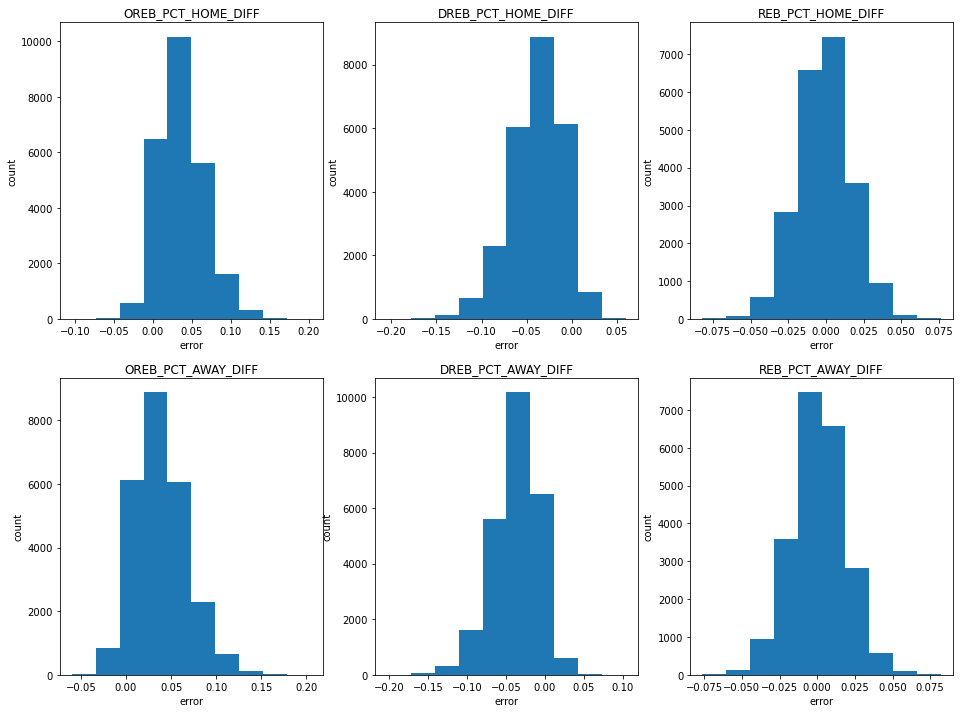

In [9]:
#plot error of calculated rebound percentage stats
fig, axes = plt.subplots(2, 3, figsize=[16, 12])

axes[0,0].hist(team_boxscores_df['OREB_PCT_CALC_HOME_DIFF'])
axes[0,0].set_title('OREB_PCT_HOME_DIFF')
axes[0,0].set_xlabel('error')
axes[0,0].set_ylabel('count')

axes[0,1].hist(team_boxscores_df['DREB_PCT_CALC_HOME_DIFF'])
axes[0,1].set_title('DREB_PCT_HOME_DIFF')
axes[0,1].set_xlabel('error')
axes[0,1].set_ylabel('count')

axes[0,2].hist(team_boxscores_df['REB_PCT_CALC_HOME_DIFF'])
axes[0,2].set_title('REB_PCT_HOME_DIFF')
axes[0,2].set_xlabel('error')
axes[0,2].set_ylabel('count')

axes[1,0].hist(team_boxscores_df['OREB_PCT_CALC_AWAY_DIFF'])
axes[1,0].set_title('OREB_PCT_AWAY_DIFF')
axes[1,0].set_xlabel('error')
axes[1,0].set_ylabel('count')

axes[1,1].hist(team_boxscores_df['DREB_PCT_CALC_AWAY_DIFF'])
axes[1,1].set_title('DREB_PCT_AWAY_DIFF')
axes[1,1].set_xlabel('error')
axes[1,1].set_ylabel('count')

axes[1,2].hist(team_boxscores_df['REB_PCT_CALC_AWAY_DIFF'])
axes[1,2].set_title('REB_PCT_AWAY_DIFF')
axes[1,2].set_xlabel('error')
axes[1,2].set_ylabel('count')

In [10]:
#fill in missing rebound percentage stats with calculated values
rebound_pct_cols = ['OREB_PCT_HOME', 'DREB_PCT_HOME', 'REB_PCT_HOME', 'OREB_PCT_AWAY', 'DREB_PCT_AWAY', 'REB_PCT_AWAY']

for col in rebound_pct_cols:
    team_boxscores_df[col].fillna(value=team_boxscores_df[col + '_CALC'], inplace=True)

team_boxscores_df.drop(columns=['OREB_PCT_CALC_HOME_DIFF',
                                'DREB_PCT_CALC_HOME_DIFF',
                                'REB_PCT_CALC_HOME_DIFF',
                                'OREB_PCT_CALC_AWAY_DIFF',
                                'DREB_PCT_CALC_AWAY_DIFF',
                                'REB_PCT_CALC_AWAY_DIFF',
                                'OREB_PCT_HOME_CALC',
                                'DREB_PCT_HOME_CALC',
                                'REB_PCT_HOME_CALC',
                                'OREB_PCT_AWAY_CALC',
                                'DREB_PCT_AWAY_CALC',
                                'REB_PCT_AWAY_CALC'], inplace=True)

In [11]:
#change W/L column to 1's and 0's
team_boxscores_df['WL_HOME'] = team_boxscores_df['WL_HOME'].map({'W':1, 'L':0})
team_boxscores_df['WL_AWAY'] = team_boxscores_df['WL_AWAY'].map({'W':1, 'L':0})

team_boxscores_df.head()

,SEASON,TEAM_ID_HOME,GAME_ID,GAME_DATE,WL_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,TEAM_CITY_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,TEAM_ID_AWAY,WL_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,TEAM_CITY_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY
1314,2021-22,1610612738,0042100404,2022-06-10,0,34,85,0.400,15,38,0.395,14,19,0.737,11,31,42,22,8,6,16,17,97,-10,Boston,98.6,101.0,109.6,111.5,-11.0,-10.4,0.647,1.38,16.7,0.264,0.615,0.438,16.267,16.7,0.488,0.519,1.0,0.196,97.98,96.0,80.00,96.0,0.448,1610612744,1,40,91,0.440,15,43,0.349,12,15,0.800,16,39,55,20,10,5,16,21,107,10,Golden State,109.6,111.5,98.6,101.0,11.0,10.4,0.500,1.25,15.0,0.385,0.736,0.562,16.393,16.7,0.522,0.548,1.0,0.201,97.98,96.0,80.00,96.0,0.552
1313,2021-22,1610612738,0042100403,2022-06-08,1,43,89,0.483,13,35,0.371,17,24,0.708,15,32,47,28,7,7,12,17,116,16,Boston,120.1,122.1,104.6,106.4,15.5,15.7,0.651,2.33,20.1,0.408,0.810,0.593,12.428,12.6,0.556,0.583,1.0,0.201,96.08,94.5,78.75,95.0,0.597,1610612744,0,36,78,0.462,15,40,0.375,13,15,0.867,6,25,31,22,7,5,17,23,100,-16,Golden State,104.6,106.4,120.1,122.1,-15.5,-15.7,0.611,1.29,17.8,0.190,0.592,0.407,17.782,18.1,0.558,0.591,1.0,0.199,96.08,94.5,78.75,94.0,0.403
1312,2021-22,1610612744,0042100402,2022-06-05,1,39,86,0.453,15,37,0.405,14,20,0.700,6,36,42,25,15,2,12,17,107,19,Golden State,106.2,110.3,87.6,89.8,18.6,20.5,0.641,2.08,19.0,0.224,0.780,0.505,11.905,12.4,0.541,0.564,1.0,0.200,100.64,97.5,81.25,97.0,0.602,1610612738,0,30,80,0.375,15,37,0.405,13,17,0.765,6,37,43,24,5,7,19,18,88,-19,Boston,87.6,89.8,106.2,110.3,-18.6,-20.5,0.800,1.26,18.4,0.220,0.776,0.495,18.909,19.4,0.469,0.503,1.0,0.197,100.64,97.5,81.25,98.0,0.398
1311,2021-22,1610612744,0042100401,2022-06-02,0,39,88,0.443,19,45,0.422,11,15,0.733,12,27,39,24,8,6,14,16,108,-12,Golden State,111.8,114.9,122.4,129.0,-10.6,-14.1,0.615,1.71,18.1,0.353,0.698,0.511,14.493,14.9,0.551,0.571,1.0,0.201,97.32,93.5,77.92,94.0,0.422,1610612738,1,43,85,0.506,21,41,0.512,13,16,0.813,7,32,39,33,7,6,13,13,120,12,Boston,122.4,129.0,111.8,114.9,10.6,14.1,0.767,2.54,23.9,0.302,0.647,0.489,13.260,14.0,0.629,0.652,1.0,0.198,97.32,93.5,77.92,93.0,0.578
1310,2021-22,1610612748,0042100307,2022-05-29,0,37,88,0.420,6,30,0.200,16,24,0.667,7,37,44,16,4,5,10,18,96,-4,Miami,94.5,99.0,101.5,103.1,-6.9,-4.1,0.432,1.60,12.8,0.214,0.741,0.473,9.846,10.3,0.455,0.487,1.0,0.193,100.06,97.0,80.83,97.0,0.471,1610612738,1,35,85,0.412,11,32,0.344,19,24,0.792,10,41,51,22,4,6,13,26,100,4,Boston,101.5,103.1,94.5,99.0,6.9,4.1,0.629,1.69,16.9,0.259,0.786,0.527,13.190,13.4,0.476,0.523,1.0,0.201,100.06,97.0,80.83,97.0,0.529


In [12]:
#Compute spread actuals
team_boxscores_df['SPREAD'] = team_boxscores_df['PTS_HOME'] - team_boxscores_df['PTS_AWAY']

In [13]:
#create temp dataframe for moving average calculations
home_team_boxscores_temp_df = team_boxscores_df.iloc[:,:48]
away_team_boxscores_temp_df = pd.DataFrame(columns=home_team_boxscores_temp_df.columns)
for col in away_team_boxscores_temp_df.columns:
    if col[-4:]!='HOME':
        away_team_boxscores_temp_df[col] = team_boxscores_df[col]
    else:
        away_team_boxscores_temp_df[col] = team_boxscores_df[col[:-5] + '_AWAY']
        
team_boxscores_temp_df = pd.concat([home_team_boxscores_temp_df, away_team_boxscores_temp_df])

for col in team_boxscores_temp_df:
    if col[-4:]=='HOME':
        team_boxscores_temp_df.rename(columns={col:col[:-5]}, inplace=True)
        
team_boxscores_temp_df.head()

,SEASON,TEAM_ID,GAME_ID,GAME_DATE,WL,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
1314,2021-22,1610612738,0042100404,2022-06-10,0,34,85,0.400,15,38,0.395,14,19,0.737,11,31,42,22,8,6,16,17,97,-10,Boston,98.6,101.0,109.6,111.5,-11.0,-10.4,0.647,1.38,16.7,0.264,0.615,0.438,16.267,16.7,0.488,0.519,1.0,0.196,97.98,96.0,80.00,96.0,0.448
1313,2021-22,1610612738,0042100403,2022-06-08,1,43,89,0.483,13,35,0.371,17,24,0.708,15,32,47,28,7,7,12,17,116,16,Boston,120.1,122.1,104.6,106.4,15.5,15.7,0.651,2.33,20.1,0.408,0.810,0.593,12.428,12.6,0.556,0.583,1.0,0.201,96.08,94.5,78.75,95.0,0.597
1312,2021-22,1610612744,0042100402,2022-06-05,1,39,86,0.453,15,37,0.405,14,20,0.700,6,36,42,25,15,2,12,17,107,19,Golden State,106.2,110.3,87.6,89.8,18.6,20.5,0.641,2.08,19.0,0.224,0.780,0.505,11.905,12.4,0.541,0.564,1.0,0.200,100.64,97.5,81.25,97.0,0.602
1311,2021-22,1610612744,0042100401,2022-06-02,0,39,88,0.443,19,45,0.422,11,15,0.733,12,27,39,24,8,6,14,16,108,-12,Golden State,111.8,114.9,122.4,129.0,-10.6,-14.1,0.615,1.71,18.1,0.353,0.698,0.511,14.493,14.9,0.551,0.571,1.0,0.201,97.32,93.5,77.92,94.0,0.422
1310,2021-22,1610612748,0042100307,2022-05-29,0,37,88,0.420,6,30,0.200,16,24,0.667,7,37,44,16,4,5,10,18,96,-4,Miami,94.5,99.0,101.5,103.1,-6.9,-4.1,0.432,1.60,12.8,0.214,0.741,0.473,9.846,10.3,0.455,0.487,1.0,0.193,100.06,97.0,80.83,97.0,0.471


In [14]:
team_boxscores_temp_df.shape

(56304, 48)

In [15]:
team_boxscores_temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56304 entries, 1314 to 1316
Data columns (total 48 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   SEASON        56304 non-null  object        
 1   TEAM_ID       56304 non-null  int64         
 2   GAME_ID       56304 non-null  object        
 3   GAME_DATE     56304 non-null  datetime64[ns]
 4   WL            56304 non-null  int64         
 5   FGM           56304 non-null  int64         
 6   FGA           56304 non-null  int64         
 7   FG_PCT        56304 non-null  float64       
 8   FG3M          56304 non-null  int64         
 9   FG3A          56304 non-null  int64         
 10  FG3_PCT       56304 non-null  float64       
 11  FTM           56304 non-null  int64         
 12  FTA           56304 non-null  int64         
 13  FT_PCT        56304 non-null  float64       
 14  OREB          56304 non-null  int64         
 15  DREB          56304 non-null  int6

array([[<AxesSubplot:title={'center':'TEAM_ID'}>,
        <AxesSubplot:title={'center':'GAME_DATE'}>,
        <AxesSubplot:title={'center':'WL'}>,
        <AxesSubplot:title={'center':'FGM'}>,
        <AxesSubplot:title={'center':'FGA'}>,
        <AxesSubplot:title={'center':'FG_PCT'}>,
        <AxesSubplot:title={'center':'FG3M'}>],
       [<AxesSubplot:title={'center':'FG3A'}>,
        <AxesSubplot:title={'center':'FG3_PCT'}>,
        <AxesSubplot:title={'center':'FTM'}>,
        <AxesSubplot:title={'center':'FTA'}>,
        <AxesSubplot:title={'center':'FT_PCT'}>,
        <AxesSubplot:title={'center':'OREB'}>,
        <AxesSubplot:title={'center':'DREB'}>],
       [<AxesSubplot:title={'center':'REB'}>,
        <AxesSubplot:title={'center':'AST'}>,
        <AxesSubplot:title={'center':'STL'}>,
        <AxesSubplot:title={'center':'BLK'}>,
        <AxesSubplot:title={'center':'TOV'}>,
        <AxesSubplot:title={'center':'PF'}>,
        <AxesSubplot:title={'center':'PTS'}>],
       [<

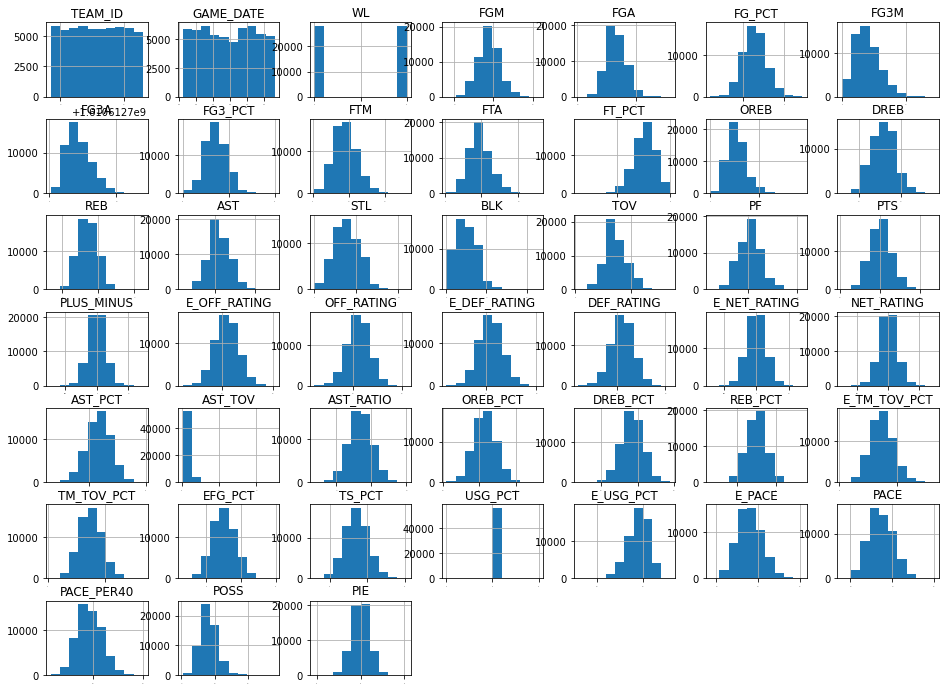

In [16]:
#check distribution of data
team_boxscores_temp_df.hist(figsize=(16,12), xlabelsize=0)

In [17]:
#turn each row's stats into average of last n games
n = 20
non_metric_cols = set(['SEASON', 'TEAM_ID_HOME', 'GAME_ID', 'GAME_DATE', 'TEAM_CITY_HOME', 'TEAM_ID_AWAY','TEAM_CITY_AWAY', 'SPREAD'])
metric_cols = set(team_boxscores_df.columns) - non_metric_cols

moving_average_df = pd.DataFrame(columns=team_boxscores_df.columns)

for i, row in tqdm(team_boxscores_df.iterrows()):
    game_date = row['GAME_DATE']
    home_team = row['TEAM_ID_HOME']
    away_team = row['TEAM_ID_AWAY']
    
    #team_boxscores_historic_df = team_boxscores_temp_df[team_boxscores_temp_df['GAME_DATE'] < game_date].copy()
    
    #if len(team_boxscores_historic_df)==0:
    #    continue
    
    home_team_temp_df = team_boxscores_temp_df[(team_boxscores_temp_df['TEAM_ID']==home_team) &
                                               (team_boxscores_temp_df['GAME_DATE']<game_date)].copy()
    away_team_temp_df = team_boxscores_temp_df[(team_boxscores_temp_df['TEAM_ID']==away_team) &
                                               (team_boxscores_temp_df['GAME_DATE']<game_date)].copy()
    
    if len(home_team_temp_df)<n or len(away_team_temp_df)<n:
        continue
    
    home_team_temp_df.sort_values(by='GAME_DATE', ascending=False, inplace=True)
    away_team_temp_df.sort_values(by='GAME_DATE', ascending=False, inplace=True)
    
    home_team_temp_df = home_team_temp_df.iloc[:n].copy()
    away_team_temp_df = away_team_temp_df.iloc[:n].copy()
    
    new_row = defaultdict()
    for col in team_boxscores_df.columns:
        if col in non_metric_cols:
            new_row[col] = row[col]
        elif col[-4:]=='HOME':
            new_row[col] = home_team_temp_df[col[:-5]].mean()
        elif col[-4:]=='AWAY':
            new_row[col] = away_team_temp_df[col[:-5]].mean()
    moving_average_df = moving_average_df.append(new_row, ignore_index=True)


28152it [31:51, 14.73it/s] 


In [18]:
moving_average_df.head()

,SEASON,TEAM_ID_HOME,GAME_ID,GAME_DATE,WL_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,TEAM_CITY_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,TEAM_ID_AWAY,WL_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,TEAM_CITY_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,SPREAD
0,2021-22,1610612738,0042100404,2022-06-10,0.65,37.00,81.65,0.45365,13.95,37.40,0.36795,18.90,23.50,0.80635,8.60,34.25,42.85,24.85,6.20,6.45,14.05,21.20,106.85,5.90,Boston,109.815,111.965,102.910,105.355,6.905,6.595,0.67540,1.8915,18.970,0.26160,0.71300,0.49690,14.41200,14.700,0.53860,0.58170,1.0,0.19870,97.779,95.725,79.771,95.60,0.54305,1610612744,0.70,42.00,85.25,0.49515,14.20,36.25,0.39395,15.55,20.50,0.76370,9.40,34.05,43.45,27.85,7.15,4.85,14.85,21.00,113.75,4.95,Golden State,114.320,116.385,109.195,111.425,5.115,4.960,0.66345,2.0100,20.330,0.27280,0.72935,0.51345,14.82955,15.115,0.57910,0.6056,1.0,0.19740,99.712,97.800,81.5000,97.90,0.53445,-10
1,2021-22,1610612738,0042100403,2022-06-08,0.65,36.95,81.65,0.45310,13.90,37.30,0.36760,19.00,23.50,0.81055,8.55,34.10,42.65,24.65,6.45,6.35,14.20,21.55,106.80,5.15,Boston,109.530,111.725,103.405,105.910,6.125,5.800,0.67140,1.8550,18.830,0.26205,0.71195,0.49630,14.53640,14.835,0.53775,0.58145,1.0,0.19870,97.978,95.875,79.896,95.75,0.53900,1610612744,0.75,41.85,85.40,0.49240,13.85,35.85,0.38770,16.20,21.40,0.75975,9.75,34.70,44.45,27.90,7.20,4.65,14.60,20.95,113.75,6.05,Golden State,114.380,116.220,107.895,110.115,6.475,6.105,0.66775,2.0415,20.320,0.27605,0.74095,0.52005,14.57525,14.830,0.57405,0.6022,1.0,0.19760,99.768,97.950,81.6250,98.05,0.54245,16
2,2021-22,1610612744,0042100402,2022-06-05,0.75,42.45,85.95,0.49605,13.90,35.60,0.39245,16.00,20.90,0.77475,9.90,34.70,44.60,28.60,6.95,4.80,14.75,21.40,114.80,5.90,Golden State,115.030,116.685,108.575,110.910,6.445,5.780,0.67395,2.0675,20.625,0.27790,0.73945,0.52035,14.67830,14.910,0.57740,0.60555,1.0,0.19755,100.189,98.400,82.000,98.55,0.54260,1610612738,0.70,38.15,82.60,0.46160,14.05,37.85,0.36610,19.00,23.30,0.82230,8.95,34.35,43.30,25.15,6.45,6.10,14.00,21.65,109.35,7.55,Boston,111.725,113.985,103.340,105.785,8.385,8.180,0.66290,1.9055,19.015,0.27215,0.70695,0.50030,14.30035,14.595,0.54610,0.5895,1.0,0.19880,98.211,96.125,80.1045,96.00,0.55050,19
3,2021-22,1610612744,0042100401,2022-06-02,0.80,42.55,85.50,0.49985,13.75,35.05,0.39490,16.00,20.90,0.77475,9.65,35.35,45.00,28.85,6.95,4.90,14.90,22.00,114.85,7.45,Golden State,115.140,116.615,107.020,109.195,8.110,7.425,0.67855,2.0675,20.820,0.27275,0.74590,0.52360,14.84275,15.050,0.58085,0.60885,1.0,0.19735,100.177,98.500,82.083,98.65,0.55245,1610612738,0.65,38.15,82.70,0.46100,14.05,38.30,0.36150,19.05,23.45,0.81850,9.00,34.55,43.55,25.00,6.50,6.00,14.15,21.75,109.40,6.65,Boston,111.460,113.410,103.900,106.145,7.560,7.245,0.65945,1.8725,18.880,0.26705,0.70920,0.49905,14.41135,14.670,0.54540,0.5886,1.0,0.19885,98.510,96.625,80.5210,96.50,0.54605,-12
4,2021-22,1610612748,0042100307,2022-05-29,0.65,38.75,84.90,0.45885,12.15,35.70,0.34025,17.75,21.85,0.80260,9.60,31.20,40.80,22.35,8.50,3.35,13.25,20.85,107.40,4.60,Miami,109.185,113.175,106.805,108.605,2.365,4.570,0.

In [19]:
moving_average_df.describe()

,WL_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,WL_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY
count,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.0,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.00000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.0,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000
mean,0.499034,37.577217,82.863036,0.454369,7.727881,21.678489,0.353148,18.132353,23.885097,0.759791,10.967288,31.663534,42.630822,22.062648,7.562695,4.884555,14.350040,20.960148,101.014667,-0.028792,104.390138,106.005252,104.416579,106.034220,-0.026405,-0.028996,0.586255,1.684248,16.897545,0.288913,0.710820,0.499858,14.827367,15.066049,0.500708,0.541642,1.0,0.198498,96.051258,94.547872,78.789890,95.238825,0.499774,0.501802,37.606074,82.898319,0.454515,7.725408,21.665740,0.353120,18.146159,23.901954,0.759864,10.982730,31.689750,42.672480,22.093273,7.561116,4.893698,14.344916,20.951947,101.083714,0.058175,104.435948,106.05142,104.379447,105.992590,0.056467,0.058877,0.586606,1.687283,16.912124,0.289221,0.711093,0.500195,14.818278,15.056799,0.500823,0.541760,1.0,0.198501,96.068102,94.566228,78.805183,95.260489,0.500389
std,0.174868,2.637207,4.274779,0.019639,2.960020,7.880051,0.030606,2.329768,3.055972,0.036480,1.582546,2.469018,2.482729,2.438767,1.043681,0.968868,1.419855,1.921562,7.412456,5.175747,4.895068,4.909008,4.619694,4.632726,5.654506,5.371394,0.046147,0.281609,1.405773,0.032517,0.026690,0.017127,1.519919,1.550152,0.029031,0.026198,0.0,0.000631,4.037764,3.897591,3.247985,3.910886,0.037771,0.174904,2.646839,4.254509,0.019744,2.954389,7.853025,0.030324,2.314888,3.038503,0.036395,1.591114,2.471858,2.482297,2.431067,1.043449,0.971985,1.426951,1.919797,7.430384,5.179942,4.912809,4.92419,4.629187,4.640394,5.654326,5.373894,0.045848,0.283309,1.402188,0.032562,0.026628,0.017117,1.519892,1.550570,0.029100,0.026263,0.0,0.000632,4.036404,3.896166,3.246796,3.904958,0.037800
min,0.000000,29.150000,70.350000,0.377100,1.900000,6.400000,0.220550,9.550000,13.750000,0.582750,5.950000,24.150000,33.850000,14.700000,4.300000,1.600000,9.250000,14.400000,78.800000,-20.000000,83.000000,86.685000,84.600000,86.140000,-20.

In [20]:
def check_missing_vals(df):
    cols_w_missing_vals = []
    for col in df.columns:
        if df[col].isna().sum() != 0:
            cols_w_missing_vals.append(col)
    return cols_w_missing_vals

In [21]:
check_missing_vals(moving_average_df)

[]

In [22]:
moving_average_df.to_csv('moving_average_df_20.csv')

In [23]:
#turn each row's stats into weighted average of last n games
n = 20
non_metric_cols = set(['SEASON', 'TEAM_ID_HOME', 'GAME_ID', 'GAME_DATE', 'TEAM_CITY_HOME', 'TEAM_ID_AWAY','TEAM_CITY_AWAY', 'SPREAD'])
metric_cols = set(team_boxscores_df.columns) - non_metric_cols

weights = np.linspace(1.5, 0.5, n)
weighted_average_df = pd.DataFrame(columns=team_boxscores_df.columns)

for i, row in tqdm(team_boxscores_df.iterrows()):
    game_date = row['GAME_DATE']
    home_team = row['TEAM_ID_HOME']
    away_team = row['TEAM_ID_AWAY']
    
    home_team_temp_df = team_boxscores_temp_df[(team_boxscores_temp_df['TEAM_ID']==home_team) &
                                               (team_boxscores_temp_df['GAME_DATE']<game_date)].copy()
    away_team_temp_df = team_boxscores_temp_df[(team_boxscores_temp_df['TEAM_ID']==away_team) &
                                               (team_boxscores_temp_df['GAME_DATE']<game_date)].copy()
    
    if len(home_team_temp_df)<n or len(away_team_temp_df)<n:
        continue
    
    home_team_temp_df.sort_values(by='GAME_DATE', ascending=False, inplace=True)
    away_team_temp_df.sort_values(by='GAME_DATE', ascending=False, inplace=True)
    
    home_team_temp_df = home_team_temp_df.iloc[:n].copy()
    away_team_temp_df = away_team_temp_df.iloc[:n].copy()
    
    new_row = defaultdict()
    for col in team_boxscores_df.columns:
        if col in non_metric_cols:
            new_row[col] = row[col]
        elif col[-4:]=='HOME':
            new_row[col] = np.average(home_team_temp_df[col[:-5]], weights=weights)
            #new_row[col] = home_team_temp_df[col[:-5]].mean()
        elif col[-4:]=='AWAY':
            new_row[col] = np.average(away_team_temp_df[col[:-5]], weights=weights)
            #new_row[col] = away_team_temp_df[col[:-5]].mean()
    weighted_average_df = weighted_average_df.append(new_row, ignore_index=True)

weighted_average_df.head()

28152it [33:12, 14.13it/s] 


,SEASON,TEAM_ID_HOME,GAME_ID,GAME_DATE,WL_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,TEAM_CITY_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,TEAM_ID_AWAY,WL_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,TEAM_CITY_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,SPREAD
0,2021-22,1610612738,0042100404,2022-06-10,0.640789,36.760526,81.385526,0.451875,13.922368,37.060526,0.370241,18.989474,23.726316,0.800241,8.628947,34.769737,43.398684,24.861842,6.039474,6.609211,14.193421,20.639474,106.432895,5.813158,Boston,109.421974,111.618816,102.555000,105.151447,6.865658,6.452500,0.679624,1.881487,18.973158,0.263539,0.718311,0.500868,14.560147,14.859737,0.536876,0.580234,1.0,0.198711,97.748132,95.600658,79.667447,95.507895,0.544941,1610612744,0.660526,41.500000,85.417105,0.488007,14.034211,36.359211,0.387649,15.267105,19.907895,0.770700,9.581579,34.298684,43.880263,27.411842,7.109211,4.672368,14.727632,20.810526,112.301316,3.685526,Golden State,113.310789,115.152500,109.432763,111.578553,3.868816,3.573421,0.660325,1.999789,20.092632,0.273087,0.742041,0.518638,14.768170,15.033553,0.570637,0.598071,1.0,0.197597,99.338000,97.547368,81.289632,97.663158,0.528175,-10
1,2021-22,1610612738,0042100403,2022-06-08,0.622368,36.419737,80.998684,0.450055,13.947368,37.136842,0.369905,19.139474,23.700000,0.807517,8.267105,34.813158,43.080263,24.596053,6.122368,6.530263,14.376316,21.035526,105.926316,4.906579,Boston,108.738158,110.965395,102.713553,105.373947,6.023289,5.575789,0.678908,1.840158,18.843684,0.256059,0.712680,0.495511,14.726768,15.037763,0.535536,0.580041,1.0,0.198589,97.937053,95.740132,79.783684,95.614474,0.540076,1610612744,0.722368,41.740789,85.873684,0.488376,13.817105,35.961842,0.385521,15.726316,20.647368,0.763288,9.935526,35.100000,45.035526,27.744737,7.142105,4.564474,14.489474,20.680263,113.025000,5.338158,Golden State,113.852368,115.595526,108.208816,110.361711,5.633816,5.233289,0.665236,2.053434,20.220789,0.279070,0.755070,0.527541,14.485628,14.733947,0.569222,0.597139,1.0,0.197613,99.557158,97.796053,81.496868,97.943421,0.539093,16
2,2021-22,1610612744,0042100402,2022-06-05,0.709211,42.190789,86.117105,0.492275,13.781579,35.776316,0.386986,15.742105,20.471053,0.773933,10.207895,35.031579,45.239474,28.247368,6.606579,4.778947,14.701316,21.113158,113.905263,4.581579,Golden State,114.607895,116.139605,109.616974,111.828421,4.980658,4.313158,0.669743,2.064408,20.442763,0.282734,0.752264,0.528483,14.677692,14.901842,0.572637,0.600825,1.0,0.197462,99.721763,98.044737,81.704105,98.248684,0.536034,1610612738,0.681579,37.385526,81.560526,0.458416,13.964474,37.427632,0.367187,19.455263,23.942105,0.815789,8.601316,34.785526,43.386842,24.880263,6.198684,6.371053,14.023684,21.272368,108.190789,7.377632,Boston,110.989868,113.249342,102.533947,105.080395,8.454605,8.150000,0.667889,1.896724,18.958816,0.263322,0.706809,0.497579,14.378607,14.677500,0.543329,0.588195,1.0,0.198729,97.913447,95.779605,79.816671,95.621053,0.553247,19
3,2021-22,1610612744,0042100401,2022-06-02,0.773684,42.422368,85.784211,0.496967,13.438158,35.006579,0.386655,16.005263,20.781579,0.776130,9.972368,35.761842,45.734

In [24]:
weighted_average_df.describe()

,WL_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,WL_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY
count,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.0,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.0,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000,27834.000000
mean,0.498717,37.579754,82.865800,0.454387,7.734642,21.699031,0.353141,18.130493,23.880789,0.759849,10.962619,31.664730,42.627349,22.064453,7.560602,4.882486,14.348273,20.958961,101.024643,-0.039843,104.396322,106.011431,104.434366,106.052334,-0.037999,-0.040931,0.586258,1.684522,16.898822,0.288821,0.710858,0.499825,14.824896,15.063531,0.500765,0.541692,1.0,0.198497,96.054818,94.551434,78.792859,95.242573,0.499684,0.502059,37.614679,82.909639,0.454553,7.733552,21.685642,0.353161,18.147345,23.902611,0.759892,10.983807,31.693664,42.677472,22.099620,7.562139,4.893980,14.341688,20.947713,101.110255,0.067278,104.455264,106.072166,104.389373,106.003367,0.065844,0.068840,0.586643,1.688203,16.915004,0.289247,0.711123,0.500225,14.813937,15.052534,0.500903,0.541832,1.0,0.198500,96.075860,94.573034,78.810854,95.266749,0.500469
std,0.177970,2.661560,4.305816,0.020030,2.969247,7.896169,0.031553,2.368663,3.098903,0.037177,1.605264,2.499114,2.524515,2.464049,1.062534,0.984648,1.444778,1.945765,7.465390,5.257299,4.958702,4.971214,4.685085,4.697101,5.742047,5.456772,0.046647,0.285543,1.423891,0.032923,0.027172,0.017473,1.542358,1.572973,0.029383,0.026545,0.0,0.000650,4.058848,3.918393,3.265319,3.934659,0.038363,0.178021,2.673681,4.287725,0.020110,2.966974,7.872438,0.031285,2.355429,3.086036,0.036987,1.614510,2.495805,2.522809,2.461669,1.063622,0.987711,1.451069,1.942740,7.485458,5.261893,4.978978,4.989523,4.701462,4.711084,5.742332,5.460312,0.046498,0.288385,1.422973,0.032976,0.027101,0.017460,1.541754,1.573020,0.029451,0.026594,0.0,0.000653,4.052874,3.912931,3.260766,3.926529,0.038374
min,0.000000,28.835526,70.327632,0.374666,1.864474,6.147368,0.218171,9.111842,13.098684,0.577920,5.882895,24.238158,33.580263,14.564474,4.189474,1.605263,9.075000,14.321053,78.782895,-20.118421,82.728816,86.134079,85.412895,87.074737,-

In [25]:
weighted_average_df.to_csv('weighted_average_df_20.csv')

In [26]:
#to do:
#correct col dtypes
#plot metric distributions and check for anamolies
#check for correlations (may need to minimize multi-colinearity in order to utilize some models)
#train and eval baseline model

In [27]:
#turn each row's stats into weighted average of last n game stats

#instead of taking average of all metrics, it may be better to recalculate some of the agg metrics (e.g FB_PCT, AST_TOV, etc.)
#over last n games